# Standing on the Shoulder of Giants

Using a Simple Python Live Trading Framework with Zipline Interface

**Algorithm & Pipeline Walkthrough**

In [1]:
import yaml
import os
import alpaca_trade_api as tradeapi
from alpaca_trade_api.common import URL
from alpaca_trade_api.entity import Aggs
import pandas as pd

def initialize_client():
    global CLIENT
    with open("config.yaml", mode='r') as f:
        o = yaml.safe_load(f)
        key = o["key_id"]
        secret = o["secret"]
        base_url = o["base_url"]
        os.environ["APCA_API_KEY_ID"] = key
        os.environ["APCA_API_SECRET_KEY"] = secret
        os.environ["APCA_API_BASE_URL"] = base_url
    CLIENT = tradeapi.REST(key_id=key,
                           secret_key=secret,
                           base_url=URL(base_url))                

initialize_client()      

In [2]:
from pylivetrader.api import *
from pipeline_live.engine import LivePipelineEngine
from pipeline_live.data.sources.alpaca import list_symbols as US_EQUITIES
from pipeline_live.data.alpaca.factors import  CustomFactor, Returns
from pipeline_live.data.alpaca.pricing import USEquityPricing
from zipline.pipeline import Pipeline

In [3]:
help('pylivetrader')
# help('pylivetrader.api')
# help('pylivetrader.algorithm')

Help on package pylivetrader:

NAME
    pylivetrader

DESCRIPTION
    # Copyright 2018 Alpaca
    #
    # Licensed under the Apache License, Version 2.0 (the "License");
    # you may not use this file except in compliance with the License.
    # You may obtain a copy of the License at
    #
    #     http://www.apache.org/licenses/LICENSE-2.0
    #
    # Unless required by applicable law or agreed to in writing, software
    # distributed under the License is distributed on an "AS IS" BASIS,
    # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    # See the License for the specific language governing permissions and
    # limitations under the License.

PACKAGE CONTENTS
    __main__
    _version
    algorithm
    api
    assets (package)
    backend (package)
    data (package)
    errors
    executor (package)
    finance (package)
    loader
    misc (package)
    protocol
    shell
    statestore (package)
    testing (package)

FILE
    /Users/mw/opt/anac

## Getting the Securities we want

Groups of tradeable stocks are refered to as "universes", because all your trades will use these stocks as their "universe" of available stock, they won't be trading with anything outside these groups.

In [4]:
from pipeline_live.data.alpaca.factors import (SimpleMovingAverage, AverageDollarVolume,)
from pipeline_live.data.sources.alpaca import list_symbols as US_EQUITIES
eng = LivePipelineEngine(US_EQUITIES)

In [5]:
# Dollar volume factor
dollar_volume = AverageDollarVolume(window_length=30)

# High dollar volume filter
high_dollar_volume = dollar_volume.percentile_between(90,100)

# Top open price filter (high dollar volume securities)
top_open_price = USEquityPricing.open.latest.top(50, mask=high_dollar_volume)

# Top percentile close price filter (high dollar volume, top 50 open price)
high_close_price = USEquityPricing.close.latest.percentile_between(90, 100, mask=top_open_price)

## Applying Filters and Factors

Let's apply our own filters, following along with some of the examples above. Let's select the following securities:

* US Stocks 
* They must be relatively highly traded stocks in the market (by dollar volume traded, need to be in the top 5% traded)

Then we'll calculate the percent difference as we've done previously. Using this percent difference we'll create an unsophisticated strategy that shorts anything with negative percent difference (the difference between the 10 day mean and the 30 day mean).

In [6]:
def make_pipeline():
    
    # Dollar volume factor
    dollar_volume = AverageDollarVolume(window_length=30)

    # Top half of dollar volume filter
    high_dollar_volume = dollar_volume.percentile_between(95,100)
    
    # 10-day close price average.
    mean_10 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=10, mask=high_dollar_volume)

    # 30-day close price average.
    mean_30 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=30, mask=high_dollar_volume)

    # Percent difference factor.
    percent_difference = (mean_10 - mean_30) / mean_30
    
    # Create a filter to select securities to short.
    shorts = percent_difference < 0
    
    # Create a filter to select securities to long.
    longs = percent_difference > 0
    
    # Filter for the securities that we want to trade.
    securities_to_trade = (shorts | longs)
    
    return Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'percent_diff':percent_difference
        },
        screen=securities_to_trade
    )

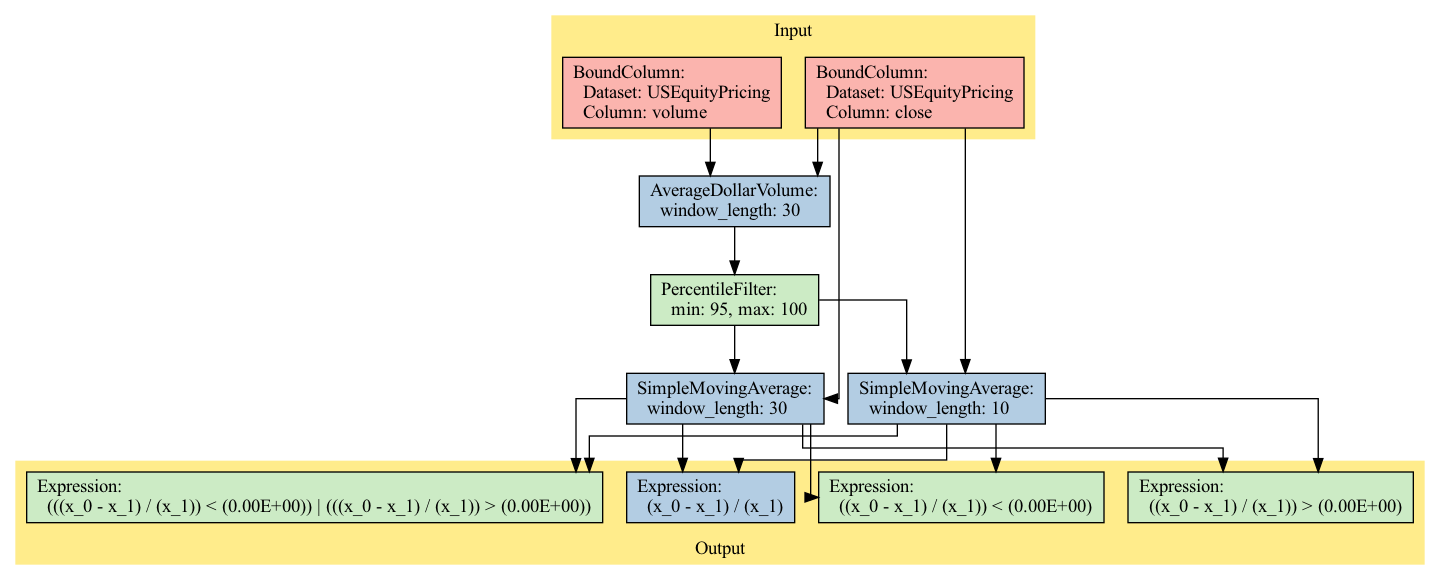

In [7]:
make_pipeline().show_graph(format='png')

In [8]:
results = eng.run_pipeline(make_pipeline())
results.dropna(inplace=True)
results.head()

/Users/mw/.zipline/data/dailycache/alpaca_chart_44: digest mismatch 0695e2a5e2bdc765d54ceec7c10e551b != 11d8d6a265f52dd842a778fff6c76d45, reloading


,longs,percent_diff,shorts
A,False,-0.050208,True
AA,False,-0.166037,True
AAL,False,-0.000703,True
AAPL,False,-0.045499,True
ABBV,False,-0.044210,True


In [9]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 550 entries, A to ZTS
Data columns (total 3 columns):
longs           550 non-null bool
percent_diff    550 non-null float64
shorts          550 non-null bool
dtypes: bool(2), float64(1)
memory usage: 9.7+ KB


In [10]:
results.to_csv('long_short_pipeline_results.csv')